# Relax Challenge

Challenge guidelines and answer in pdfs also in repository.

In [80]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
%matplotlib inline

In [38]:
# Read in and check the datasets
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
users = pd.read_csv('takehome_users.csv', parse_dates=True, encoding='latin-1')

In [39]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [40]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [41]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [42]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


The goal is to define an 'adopted user' as someone who logs in at least three separate times in a seven day period and from there predict which factors predict future user adoption. We'll do this by first changing the `time_stamp` to a datetime object.

In [43]:
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp')

In [44]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [45]:
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [46]:
# Resampling the dataset and counting up the number of visits
engage_g = engage.groupby('user_id').resample('1W').sum()

In [47]:
# Dropping the doubled user_id, now index
engage_g = engage_g.drop('user_id', axis=1)

In [48]:
# Determining which weeks are considered active for the user
active = (engage_g['visited'] >= 3) * 1

In [49]:
active.head(15)

user_id  time_stamp
1        2014-04-27    0
2        2013-11-17    0
         2013-11-24    0
         2013-12-01    0
         2013-12-08    0
         2013-12-15    0
         2013-12-22    0
         2013-12-29    0
         2014-01-05    0
         2014-01-12    0
         2014-01-19    0
         2014-01-26    0
         2014-02-02    0
         2014-02-09    1
         2014-02-16    0
Name: visited, dtype: int64

In [50]:
# Grouping by user for joining. The value is active weeks.
active = active.groupby(level=0).sum()

In [51]:
active.head(15)

user_id
1      0
2      1
3      0
4      0
5      0
6      0
7      0
10    52
11     0
13     0
14     0
17     0
19     0
20     1
21     0
Name: visited, dtype: int64

In [52]:
# Creating dataframe for joining
active_users = pd.DataFrame(active, index=active.index)
active_users.columns = ['active_weeks']

In [53]:
active_users.head()

,active_weeks
user_id,
1,0
2,1
3,0
4,0
5,0


In [54]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [55]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 1 columns):
active_weeks    8823 non-null int64
dtypes: int64(1)
memory usage: 137.9 KB


The users dataframe has far more `object_id` indicating that a number of users are not using the platform. As such, we'll need to use a left join to not lose that data.

In [69]:
# Joining dataframes
df = users.merge(active_users, how='left', left_on='object_id', right_index=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
active_weeks                  8823 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


In [71]:
# Adding an adopted user column based on active weeks
df['adopted_user'] = [1 if x >= 1 else 0 for x in df.active_weeks]

In [72]:
df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,52.0,1


In [73]:
# Checking everything worked correctly
df.loc[df.active_weeks == 0].adopted_user.unique()

array([0])

In [74]:
df.loc[df.active_weeks >= 1].adopted_user.unique()

array([1])

In [75]:
df.adopted_user.unique()

array([0, 1])

In [123]:
# Dropping not needed features
# invited_by_user_id is handled in a creation_source option
# active weeks and time data defines the repsonse variable
# demographic data not needed
data = df.drop(['creation_time', 'name', 'email', 'last_session_creation_time', 
                'active_weeks', 'invited_by_user_id'],axis=1)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
adopted_user                  12000 non-null int64
dtypes: int64(5), object(1)
memory usage: 562.6+ KB


In [125]:
# Creating dummy variables for the creation_source feature
data = pd.get_dummies(data=data, columns=['creation_source'])

In [126]:
data.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,0,1,0,0,0,0
1,2,0,0,1,1,0,1,0,0,0
2,3,0,0,94,0,0,1,0,0,0
3,4,0,0,1,0,1,0,0,0,0
4,5,0,0,193,0,1,0,0,0,0


Text(0, 0.5, 'Number of Users')

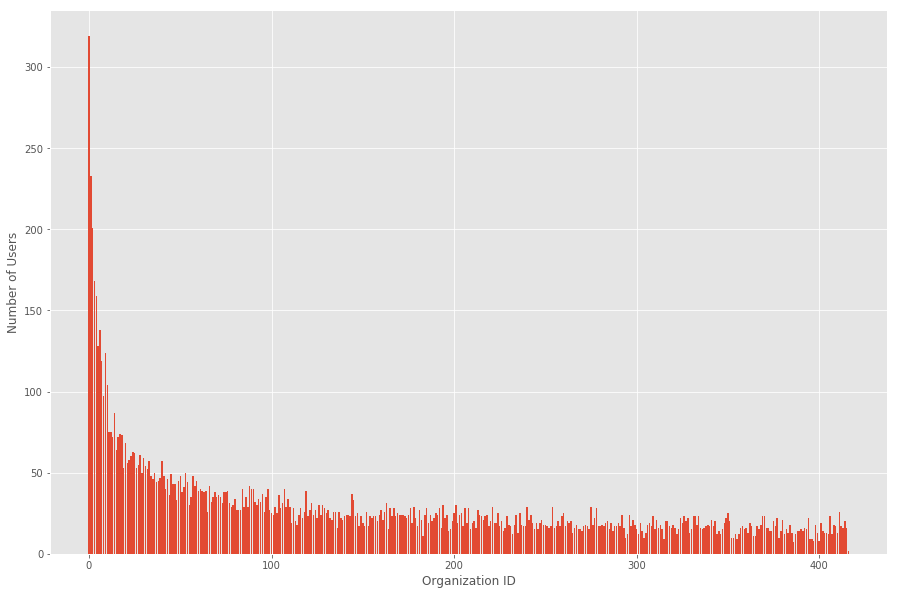

In [127]:
# The org_id is a bit all over the place and could negatively affect results. Let's visualize.
org_counts = data.org_id.value_counts()
plt.figure(figsize=(15,10))
plt.bar(org_counts.index, org_counts.values)
plt.xlabel('Organization ID')
plt.ylabel('Number of Users')

In [128]:
data.org_id.nunique()

417

There are far too many `org_id`s to provide solid analysis, we can group the data by `org_id` and cluster them by the number of `adopted_user`. This reduces dimensionality compared to creating a dummy variable for each `org_id` while retaining the major information of the data.

In [129]:
# Check how many clusters that would be
org = data.groupby('org_id').sum()
org.adopted_user.unique()

array([11, 14, 13,  9, 16,  8, 10,  7,  6,  4,  5,  3,  2,  1, 12,  0])

In [130]:
# Saving org_id for reference
orgs = data[['org_id']]
orgs.head()

,org_id
0,11
1,1
2,94
3,1
4,193


In [131]:
# Loop over the org_id and assign them a cluster by adopted_user number
org_group = []
for i in data['org_id']:
    group = org.loc[i,'adopted_user']
    org_group.append(group)
data['org_id'] = org_group

In [132]:
# Creating org_id/org_group reference df
orgs['org_group'] = org_group
orgs.head()

/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,org_id,org_group
0,11,7
1,1,14
2,94,6
3,1,14
4,193,3


In [133]:
# Checking
orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
org_id       12000 non-null int64
org_group    12000 non-null int64
dtypes: int64(2)
memory usage: 187.6 KB


In [134]:
# Checking
test = orgs.groupby('org_id').nunique()
test.org_group.nunique()

1

Ok, all `org_id`s exist in only one grouping.

In [135]:
# Get dummy variables for the now categorized org_id
data = pd.get_dummies(data=data,columns=['org_id'])
data.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
0,1,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# Set object_id as index as we don't need it for modeling
data = data.set_index('object_id')
data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
# Checking the balance of the response variable
data.adopted_user.mean()

0.12041666666666667

The response variable is very imbalanced so we will use SMOTE to upscale the training data.

In [138]:
# Split the data into train and test sets
X = data.drop('adopted_user', axis=1)
y = data.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [139]:
# Upsampling the training set
smt = SMOTE(random_state=23)
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (upscaled training set):
1    7913
0    7913
dtype: int64
Mean: 0.5


Now that we have data split between training/test sets and upscaled, we can move on to fitting the model. In this case, we will use the `RandomForestClassifier`. It's good out of the box without intense tuning and adept at determining feature importance. Tree-based classifiers have a built in `.feature_importances_` which can be called after fitting. Even though we have upscaled the data, we will use the F1-score as a metric and not accuracy to avoid issues in testing.

In [140]:
# Tuning RandomForestClassifier model with RandomizedSearchCV to narrow down parameter tuning
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


rf = RandomForestClassifier(random_state=23, n_jobs=-1)
rf_rs = RandomizedSearchCV(rf, param_grid, scoring='f1', random_state=23, n_iter=100, cv=3, n_jobs=-1)
%time rf_rs.fit(X_train, y_train)

CPU times: user 10.6 s, sys: 639 ms, total: 11.2 s
Wall time: 18min 45s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=23, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [141]:
# Checking the best parameters
best_params = rf_rs.best_params_
best_params

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [142]:
# Checking the best score
best_f1 = rf_rs.best_score_
print("Best F1 score:", best_f1)

Best F1 score: 0.6729891295388243


In [144]:
# Building the smaller parameter grid for GridSearchCV
n_estimators = [1790, 1000, 1810]
min_samples_split = [10, 11, 12]
min_samples_leaf = [1, 2]
max_depth = [7, 8, 9, 10]
param_grid = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}

rf = RandomForestClassifier(random_state=23, max_features='auto', bootstrap=False, n_jobs=-1)
rf_gs = GridSearchCV(rf, param_grid, scoring='f1', cv=3)
%time rf_gs.fit(X_train, y_train)

CPU times: user 16min 3s, sys: 1min 42s, total: 17min 46s
Wall time: 22min 48s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1790, 1000, 1810], 'min_samples_split': [10, 11, 12], 'min_samples_leaf': [1, 2], 'max_depth': [7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [145]:
# Checking the best parameters
best_params = rf_gs.best_params_
best_params

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 1810}

In [146]:
# Checking the best score
best_f1 = rf_gs.best_score_
print("Best F1 score:", best_f1)

Best F1 score: 0.6735160906138404


In [147]:
best_rf = RandomForestClassifier(random_state=23, max_features='auto', bootstrap=False, n_jobs=-1, 
           max_depth=10, min_samples_leaf=1, min_samples_split=12, n_estimators=1810)
%time best_rf.fit(X_train, y_train)

best_pred = best_rf.predict(X_test)
print(confusion_matrix(y_test, best_pred))
print(classification_report(y_test, best_pred))

CPU times: user 17.5 s, sys: 595 ms, total: 18.1 s
Wall time: 6.08 s
[[1254 1388]
 [ 120  238]]
              precision    recall  f1-score   support

           0       0.91      0.47      0.62      2642
           1       0.15      0.66      0.24       358

   micro avg       0.50      0.50      0.50      3000
   macro avg       0.53      0.57      0.43      3000
weighted avg       0.82      0.50      0.58      3000



In [148]:
# Creating a dataframe of feature importances
feature_import = pd.DataFrame(best_rf.feature_importances_).transpose()

In [149]:
feature_import.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.075322,0.082211,0.044868,0.033063,0.11325,0.027539,0.026332,0.154104,0.116559,0.021101,...,0.053109,0.004451,0.019604,0.006702,0.002712,0.073549,0.001077,0.042175,0.037493,0.008385


In [150]:
feature_import.columns = list(data.drop('adopted_user', axis=1).columns)

In [151]:
feature_import.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,org_id_2,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
0,0.075322,0.082211,0.044868,0.033063,0.11325,0.027539,0.026332,0.154104,0.116559,0.021101,...,0.053109,0.004451,0.019604,0.006702,0.002712,0.073549,0.001077,0.042175,0.037493,0.008385


In [152]:
# Complete dataframe of feature importances arranged from highest to lowest
feature_import.index = ['RFC Feature Importances']
feature_import.transpose().sort_values(by='RFC Feature Importances',ascending=False)

,RFC Feature Importances
org_id_0,0.154104
org_id_1,0.116559
creation_source_PERSONAL_PROJECTS,0.113250
enabled_for_marketing_drip,0.082211
opted_in_to_mailing_list,0.075322
org_id_11,0.073549
org_id_6,0.053109
creation_source_GUEST_INVITE,0.044868
org_id_13,0.042175
org_id_5,0.038318


In [155]:
# Series is easier to barplot
fi = pd.Series(best_rf.feature_importances_, X.columns).sort_values(ascending=False)

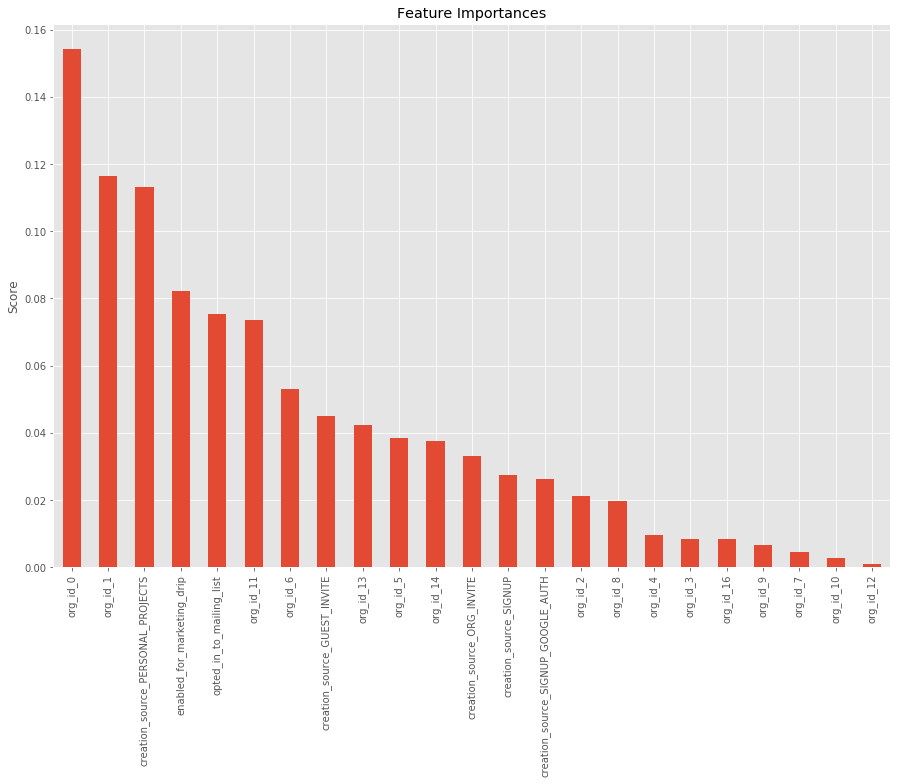

In [156]:
fi.plot(kind='bar', title='Feature Importances', figsize=[15,10])
plt.ylabel('Score')
plt.savefig('fi.png')

In [157]:
# Checking the top 3 org_ids. Org Group 0
orgs.loc[orgs.org_group==0].org_id.unique()

array([310, 242, 307, 374, 329, 151, 365, 338, 237, 346, 362, 394, 412,
       299, 386, 279, 348, 355, 183, 396, 416])

In [158]:
# Org Group 1
orgs.loc[orgs.org_group==1].org_id.unique()

array([276,  51, 229, 409,  86, 402, 373, 406, 410, 244, 255, 349, 153,
        87, 137, 376, 380, 171, 143, 164, 327, 330, 339, 344, 158, 239,
       253, 227, 223, 351, 125, 228, 204, 259, 312, 390, 220, 308, 111,
       294, 101, 369, 379, 397, 315, 232, 384, 323])

In [159]:
# Org Group 11
orgs.loc[orgs.org_group==11].org_id.unique()

array([0, 4, 5])